# Disaster Tweets Classification

### load the data

In [460]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [461]:
df = pd.read_csv('train.csv')

In [462]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [463]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [464]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

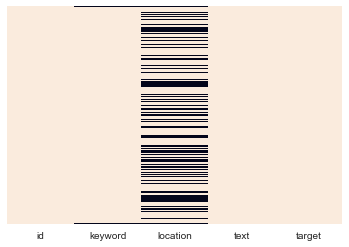

In [465]:
sns.heatmap(df.isnull(), yticklabels=[], cmap='rocket_r', cbar=False);
fig = plt.gcf()
fig.set_size_inches(6, 4) # we can see that columns keyword and location have missing values

## Exploratory Data Analysis

### target column distribution

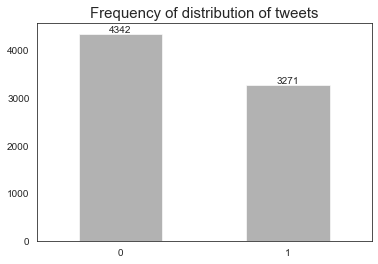

In [466]:
sns.set_style('white')
df['target'].value_counts().plot.bar(alpha=0.6, color='gray')
plt.xticks(rotation=360)
plt.title('Frequency of distribution of tweets', dict(fontsize=15))
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container)
fig = plt.gcf()
fig.set_size_inches(6, 4); 

### top 20 keywords in tweets

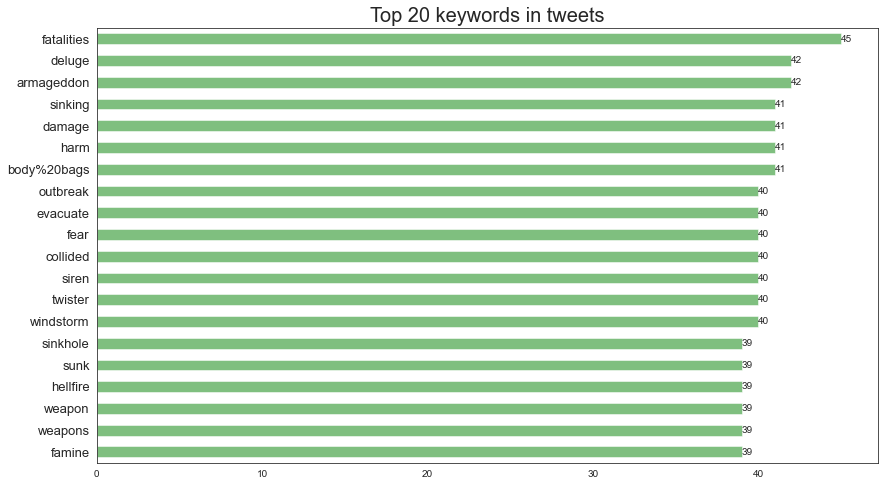

In [467]:
df['keyword'].value_counts()[:20][::-1].plot.barh(color='g', alpha=0.5)
ax = plt.gca()
for i in ax.get_yticklabels():
    i.set_fontsize(13)
for container in ax.containers:
    ax.bar_label(container);
fig = plt.gcf()
fig.set_size_inches(14,8)
plt.title('Top 20 keywords in tweets', dict(fontsize=20)); 

In [468]:
disaster_keyword = df[df['target']==1]['keyword'].value_counts()[:20]
non_disaster_keyword = df[df['target']==0]['keyword'].value_counts()[:20]

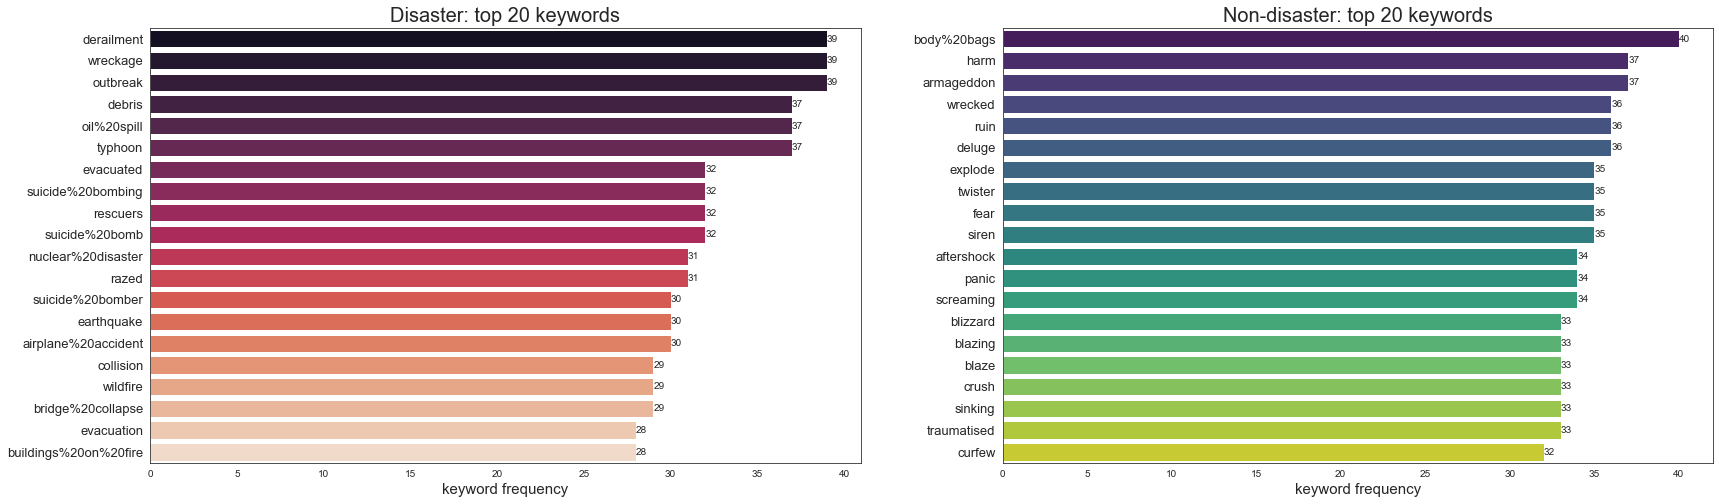

In [469]:
fig, axes = plt.subplots(1, 2,  figsize=(28, 8))
sns.barplot( x=disaster_keyword,y=disaster_keyword.index, ax=axes[0], palette='rocket')
axes[0].set_xlabel('keyword frequency', size=15)
for container in axes[0].containers:
    axes[0].bar_label(container)
axes[0].set_title('Disaster: top 20 keywords', size=20)
for i in axes[0].get_yticklabels():
    i.set_fontsize(13)
    
sns.barplot( x=non_disaster_keyword, y=non_disaster_keyword.index, ax=axes[1], palette='viridis')
axes[1].set_xlabel('keyword frequency', size=15)
for container in axes[1].containers:
    axes[1].bar_label(container)
axes[1].set_title('Non-disaster: top 20 keywords', size=20)
for i in axes[1].get_yticklabels():
    i.set_fontsize(13); 

### tweets length

In [470]:
df['length'] = df['text'].apply(len)

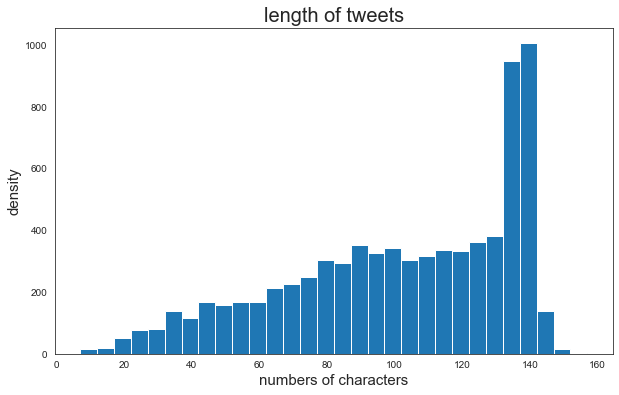

In [471]:
df['length'].plot.hist(bins=30, figsize=(10,6))
plt.xlabel('numbers of characters', size=15)
plt.ylabel('density', size=15)
plt.title('length of tweets', size=20);

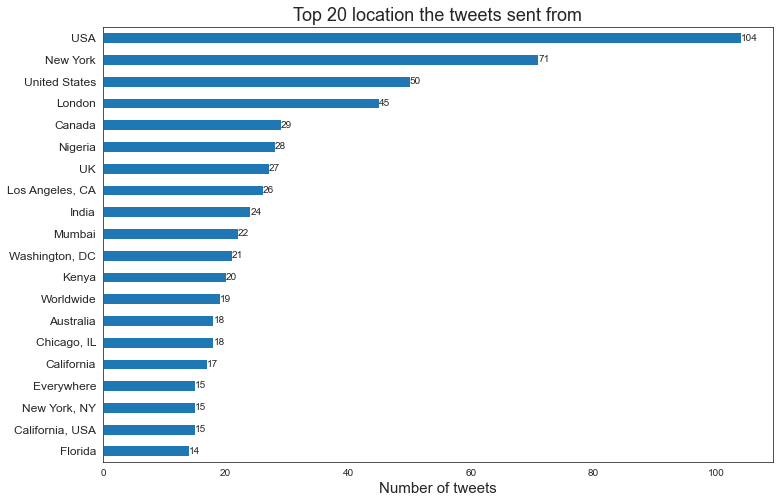

In [472]:
df['location'].value_counts()[:20][::-1].plot.barh(figsize=(12,8))
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Number of tweets',size=15)
plt.title('Top 20 location the tweets sent from', size=18)
for i in ax.get_yticklabels():
    i.set_fontsize(12);

# Data Preprocessing

### drop the missing values

In [473]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

In [475]:
df = df.dropna(axis=0)

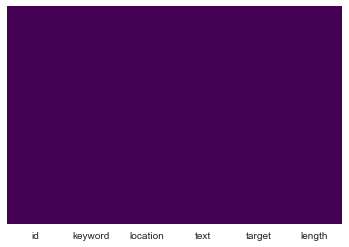

In [476]:
sns.heatmap(df.isnull(), cbar=False, yticklabels=[], cmap='viridis'); # now we don't have any missing values

In [479]:
df = df.reset_index()

In [778]:
Xtrain = df['text']
label = df['target']

### Clean the texts

In [484]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [485]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [613]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(Xtrain)):
    text = re.sub('[^a-zA-Z]', ' ', Xtrain[i])
    text = text.lower()
    text = text.split()
    
    text = [ps.stem(word) for word in text if word not  in stopwords.words('english')]
    test = ' '.join(text)
    corpus.append(text)

In [614]:
Xtrain[0] # before cleaning

'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

In [615]:
corpus[0] # after cleaning

['bbcmtd', 'wholesal', 'market', 'ablaz', 'http', 'co', 'lhyxeohi', 'c']

### build a word cloud

In [552]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [616]:
from wordcloud import WordCloud

In [617]:
corpus[0]

['bbcmtd', 'wholesal', 'market', 'ablaz', 'http', 'co', 'lhyxeohi', 'c']

In [618]:
sample_text = [' '.join(i) for i in corpus[:20]]

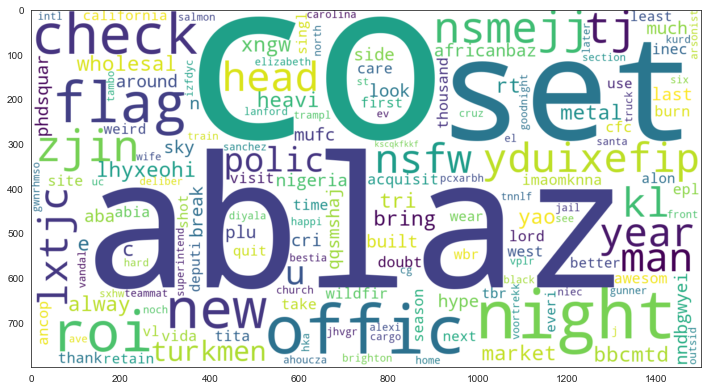

In [619]:
wordcloud = WordCloud(background_color ='white', max_words=200, width=1500, height=800, colormap='viridis').generate(' '.join(sample_text))
plt.imshow(wordcloud, interpolation='bilinear')
fig = plt.gcf()
fig.set_size_inches(12,8)

### One Hot Encoding

In [688]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [689]:
# one_hot_encoding =[one_hot(words, 5000) for words in corpus[5]]

In [690]:
Tok = Tokenizer(num_words = 5000)

In [691]:
tok.fit_on_texts(corpus)

In [692]:
sequences = tok.texts_to_sequences(corpus)

In [693]:
embedding_docs = pad_sequences(sequences, maxlen=25)

# build the model

In [694]:
from tensorflow.keras import layers, models

In [704]:
model = models.Sequential()
model.add(layers.Embedding(5000, 40, input_length=25))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(200))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 40)            200000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               192800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 393,001
Trainable params: 393,001
Non-trainable params: 0
_________________________________________________________________


### train the data

In [696]:
from sklearn.model_selection import train_test_split

In [706]:
Xtrain, Xtest, ytrain, ytest = train_test_split(embedding_docs, label)

In [707]:
model.fit(Xtrain, ytrain, epochs=20, batch_size=40, validation_data=(Xtest, ytest))

Train on 3810 samples, validate on 1270 samples
Epoch 1/20
3810/3810 [==============================] - 5s 1ms/step - loss: 0.6421 - acc: 0.6262 - val_loss: 0.5591 - val_acc: 0.7102
Epoch 2/20
3810/3810 [==============================] - 4s 995us/step - loss: 0.4208 - acc: 0.8184 - val_loss: 0.4576 - val_acc: 0.7913
Epoch 3/20
3810/3810 [==============================] - 4s 1ms/step - loss: 0.3017 - acc: 0.8785 - val_loss: 0.5662 - val_acc: 0.7858
Epoch 4/20
3810/3810 [==============================] - 4s 1ms/step - loss: 0.2508 - acc: 0.9087 - val_loss: 0.6078 - val_acc: 0.7882
Epoch 5/20
3810/3810 [==============================] - 4s 1ms/step - loss: 0.1930 - acc: 0.9304 - val_loss: 0.6125 - val_acc: 0.7787
Epoch 6/20
3810/3810 [==============================] - 4s 1ms/step - loss: 0.1494 - acc: 0.9454 - val_loss: 0.7780 - val_acc: 0.7772
Epoch 7/20
3810/3810 [==============================] - 4s 1ms/step - loss: 0.1261 - acc: 0.9570 - val_loss: 0.8969 - val_acc: 0.7709
Epoch 8/20
3

In [708]:
epochs = range(1,21)
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

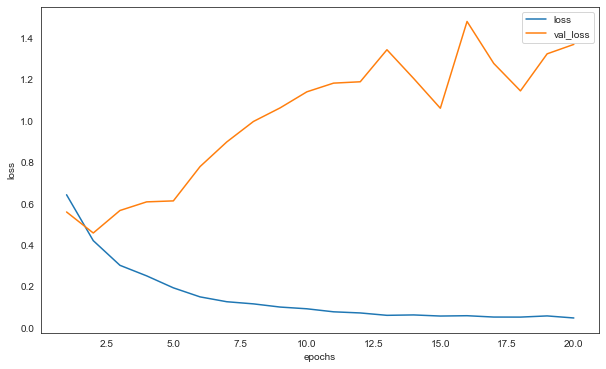

In [709]:
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10,6);

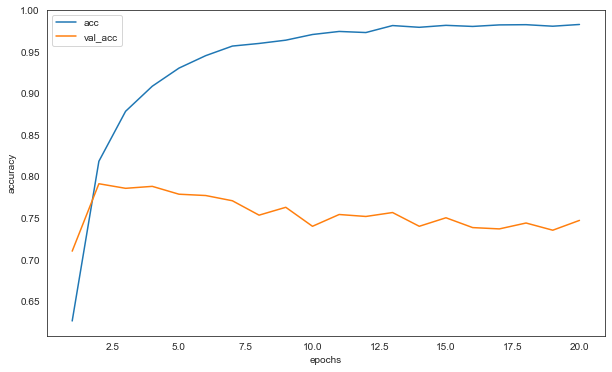

In [710]:
plt.plot(epochs, acc, label='acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10,6) # after 2 epochs,  the model starts to overfit the trian data

### load the test data and repeat the data preprocessing

In [761]:
test = pd.read_csv('test.csv')

In [762]:
testID = test['id']

In [745]:
test.isnull().sum() # double check

id          0
keyword     0
location    0
text        0
dtype: int64

In [721]:
Xtest = test['text']

In [723]:
ps = PorterStemmer()
corpus_test = []
for i in range(0, len(Xtest)):
    text = re.sub('[^a-zA-Z]', ' ', Xtest[i])
    text = text.lower()
    text = text.split()
    
    text = [ps.stem(word) for word in text if word not  in stopwords.words('english')]
    test = ' '.join(text)
    corpus_test.append(text)

In [726]:
tok.fit_on_texts(corpus_test)

In [727]:
sequence_test = tok.texts_to_sequences(corpus_test)

In [728]:
embedding_docs_test = pad_sequences(sequence_test, maxlen=25)

In [730]:
embedding_docs_test.shape

(3263, 25)

### make prediction

In [779]:
model.fit(embedding_docs, label, epochs=2, batch_size=40) # use the optimal epoch

Epoch 1/2
5080/5080 [==============================] - 5s 914us/step - loss: 0.2687 - acc: 0.9199
Epoch 2/2
5080/5080 [==============================] - 5s 902us/step - loss: 0.1626 - acc: 0.9504


In [780]:
Xtest = np.array(embedding_docs_test)

In [781]:
prediction = model.predict(Xtest).round()

In [782]:
prediction.shape

(3263, 1)

In [783]:
testID.shape

(3263,)

In [784]:
prediction_df = pd.DataFrame({'id': testID, 'prediction':[round(i[0]) for i in prediction]})

In [785]:
prediction_df

,id,prediction
0,0,0
1,2,1
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,0
3261,10874,1
